### Single nodes' bursting dynamcis

In [1]:
import sys; sys.path.insert(1, '/home/vinicius/storage1/projects/GrayData-Analysis')
import os

from   GDa.session           import session_info, session
from   GDa.util              import create_stages_time_grid
from   GDa.net.util          import compute_coherence_thresholds
from   GDa.temporal_network  import temporal_network
from   GDa.stats.bursting    import *

from   xfrites.conn.conn_coh import conn_coherence_wav
from   xfrites.conn.conn_tf  import wavelet_spec

from   mne.viz               import circular_layout, \
                                    plot_connectivity_circle

import matplotlib.pyplot     as     plt
import matplotlib
import GDa.graphics.plot     as     plot

import numpy             as np
import xarray            as xr
import matplotlib.pyplot as plt
import h5py
import scipy
from   tqdm              import tqdm

In [2]:
SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = plot.set_plot_config()

In [3]:
# Create directory to save figures
if not os.path.exists("img/n5.1.0"):
    os.makedirs("img/n5.1.0")

#### Load session and filter for ODRT trials with correct response

In [4]:
stages      = ['baseline', 'cue', 'delay', 'match']
band_names  = [r'$\theta$', r'$\alpha$', r'$\beta$', r'high-$\beta$ ', r'$\gamma$' ]

In [5]:
# Instantiate class
ses = session(raw_path = '../GrayLab/', monkey = 'lucy', date = '150128', session = 1,
              slvr_msmod = False, align_to = 'cue', evt_dt = [-0.65, 3.00])

# Read data from .mat files
ses.read_from_mat()

In [6]:
# Filtering by trials
data = ses.filter_trials(trial_type=[1],behavioral_response=[1])

#### Compute spectra for the data

In [7]:
# Smoothing windows
sm_times  = 0.5
sm_freqs  = 1
sm_kernel = "square"

# Defining parameters
delta = 15       # Downsampling factor
mode  = 'morlet' # ("morlet", "mt_1", "mt_2")
#  mode  = 'multitaper' # ("morlet", "mt_1", "mt_2")
foi   = np.array([
        [0.1, 6.],
        [6., 14.],
        [14., 26.],
        [26., 42.],
        [42., 80.]
            ])

n_freqs  = 50
freqs    = np.linspace(foi[0,0], foi[-1,1], n_freqs, endpoint=True)
n_cycles = freqs/2

In [11]:
sxx, _ = wavelet_spec(data, freqs=freqs, roi=data.roi, times="time", sfreq=data.attrs["fsample"], pairs=None,
                 foi=foi, sm_times=sm_times, sm_freqs=sm_freqs, sm_kernel=sm_kernel, mode=mode, 
                 n_cycles=n_cycles, mt_bandwidth=None, decim=delta, kw_cwt={}, 
                 kw_mt={}, block_size=1, n_jobs=20, verbose=None)

Compute auto- and cross-spectra (n_pairs=1176, n_freqs=50, decim=15, sm_times=33, sm_freqs=1)
[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  40 out of  49 | elapsed:   22.8s remaining:    5.1s
[Parallel(n_jobs=20)]: Done  49 out of  49 | elapsed:   25.7s finished


  0%|          | Estimating pairwise cross-spectra : 0/1176 [00:00<?,       ?it/s]

In [15]:
sxx = sxx.isel(times=slice(20,-20))

#### Power-Coherence correlation

In [17]:
### Methods to read coherence files
def get_coh_file(ks=None, surr=False, mode="morlet"):
    _COH_FILE = f'super_tensor_k_{ks}_surr_{surr}_{mode}.nc'
    return _COH_FILE

# Parameters to read the data
idx      = 3 
nses     = 1
nmonkey  = 0
align_to = 'cue'

dirs = { 'rawdata':'/home/vinicius/storage1/projects/GrayData-Analysis/GrayLab',
         'results':'Results/',
         'monkey' :['lucy', 'ethyl'],
         'session':'session01',
         'date'   :[['141014', '141015', '141205', '150128', '150211', '150304'], []] }

###################################################################################
# Load coherence data
###################################################################################

q_thr = None
## Default threshold
kw = dict(q=q_thr)

# Instantiating a temporal network object without thresholding the data
net =  temporal_network(coh_file=get_coh_file(ks=.5, surr=False, mode="morlet"), monkey=dirs['monkey'][nmonkey], 
                        session=1, date='150128', trial_type=[1],
                        behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                        verbose=True, **kw)

In [22]:
def pow_coh_corr(_SURR=False):
    
    ###################################################################################
    # Load coherence data
    ###################################################################################

    q_thr = None
    ## Default threshold
    kw = dict(q=q_thr)

    # Instantiating a temporal network object without thresholding the data
    net =  temporal_network(coh_file=get_coh_file(ks=0.5, surr=_SURR, mode="morlet"), monkey=dirs['monkey'][nmonkey], 
                            session=1, date='150128', trial_type=[1],
                            behavioral_response=[1], wt=(20,20), drop_trials_after=True,
                            verbose=True, **kw)
    
    # Z-score coherence and power
    z_coh = ( net.super_tensor-net.super_tensor.mean(dim="times") ) / net.super_tensor.std(dim="times")
    z_pow = ( sxx-sxx.mean(dim="times") ) / sxx.std(dim="times")
    
    x_s, x_t = net.super_tensor.attrs["sources"], net.super_tensor.attrs["targets"]
    cc       = np.zeros((z_pow.sizes["roi"],z_pow.sizes["roi"],z_coh.sizes["freqs"]))
    for f in range(z_coh.sizes["freqs"]):
        for p, (i,j) in enumerate(zip(x_s,x_t)):
            cc[i,j,f] = cc[j,i,f] = np.mean( z_coh.isel(roi=p,freqs=f)*z_pow.isel(roi=i,freqs=f)*z_pow.isel(roi=j,freqs=f) )
            
    return cc

def plot_coh_corr(mat, freq, surr=False, vmin=0, vmax=0.5):
    
    fig = plt.figure(figsize=(5,5))
    
    plot_connectivity_circle(mat[...,freq], data.roi.values, colormap="autumn_r", vmin=vmin, vmax=vmax,
                         facecolor="white", n_lines=100, textcolor="k", fig=None, colorbar=False, padding=1, linewidth=2,
                         title=None, fontsize_title=20,fontsize_names=12, subplot=111, show=False);
    
    plt.savefig(f"img/n5.1.0/cc_pow_coh_circle_surr_{surr}_f_{freq}.png", transparent=True, bbox_inches='tight', dpi=300);
    plt.close()
    
def plot_circles(ax, freq, surr=False):
    """
    Plot olympics circles to the given axes.
    """
    
    png = plt.imread(f"img/n5.1.0/cc_pow_coh_circle_surr_{surr}_f_{freq}.png")
    plt.sca(ax)
    im = plt.imshow(png, interpolation='none')
    #plt.axis('off')    
    pad = 2
    plt.xlim(-pad, png.shape[1]+pad)
    plt.ylim(png.shape[0]+pad, -pad)
    return png

In [23]:
cc      = pow_coh_corr(_SURR=False)
cc_surr = pow_coh_corr(_SURR=True)

In [24]:
plot_coh_corr(cc, 0, surr=False);
plot_coh_corr(cc, 1, surr=False);
plot_coh_corr(cc, 2, surr=False);
plot_coh_corr(cc, 3, surr=False);
plot_coh_corr(cc, 4, surr=False);

plot_coh_corr(cc_surr, 0, surr=True);
plot_coh_corr(cc_surr, 1, surr=True);
plot_coh_corr(cc_surr, 2, surr=True);
plot_coh_corr(cc_surr, 3, surr=True);
plot_coh_corr(cc_surr, 4, surr=True);

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

<Figure size 360x360 with 0 Axes>

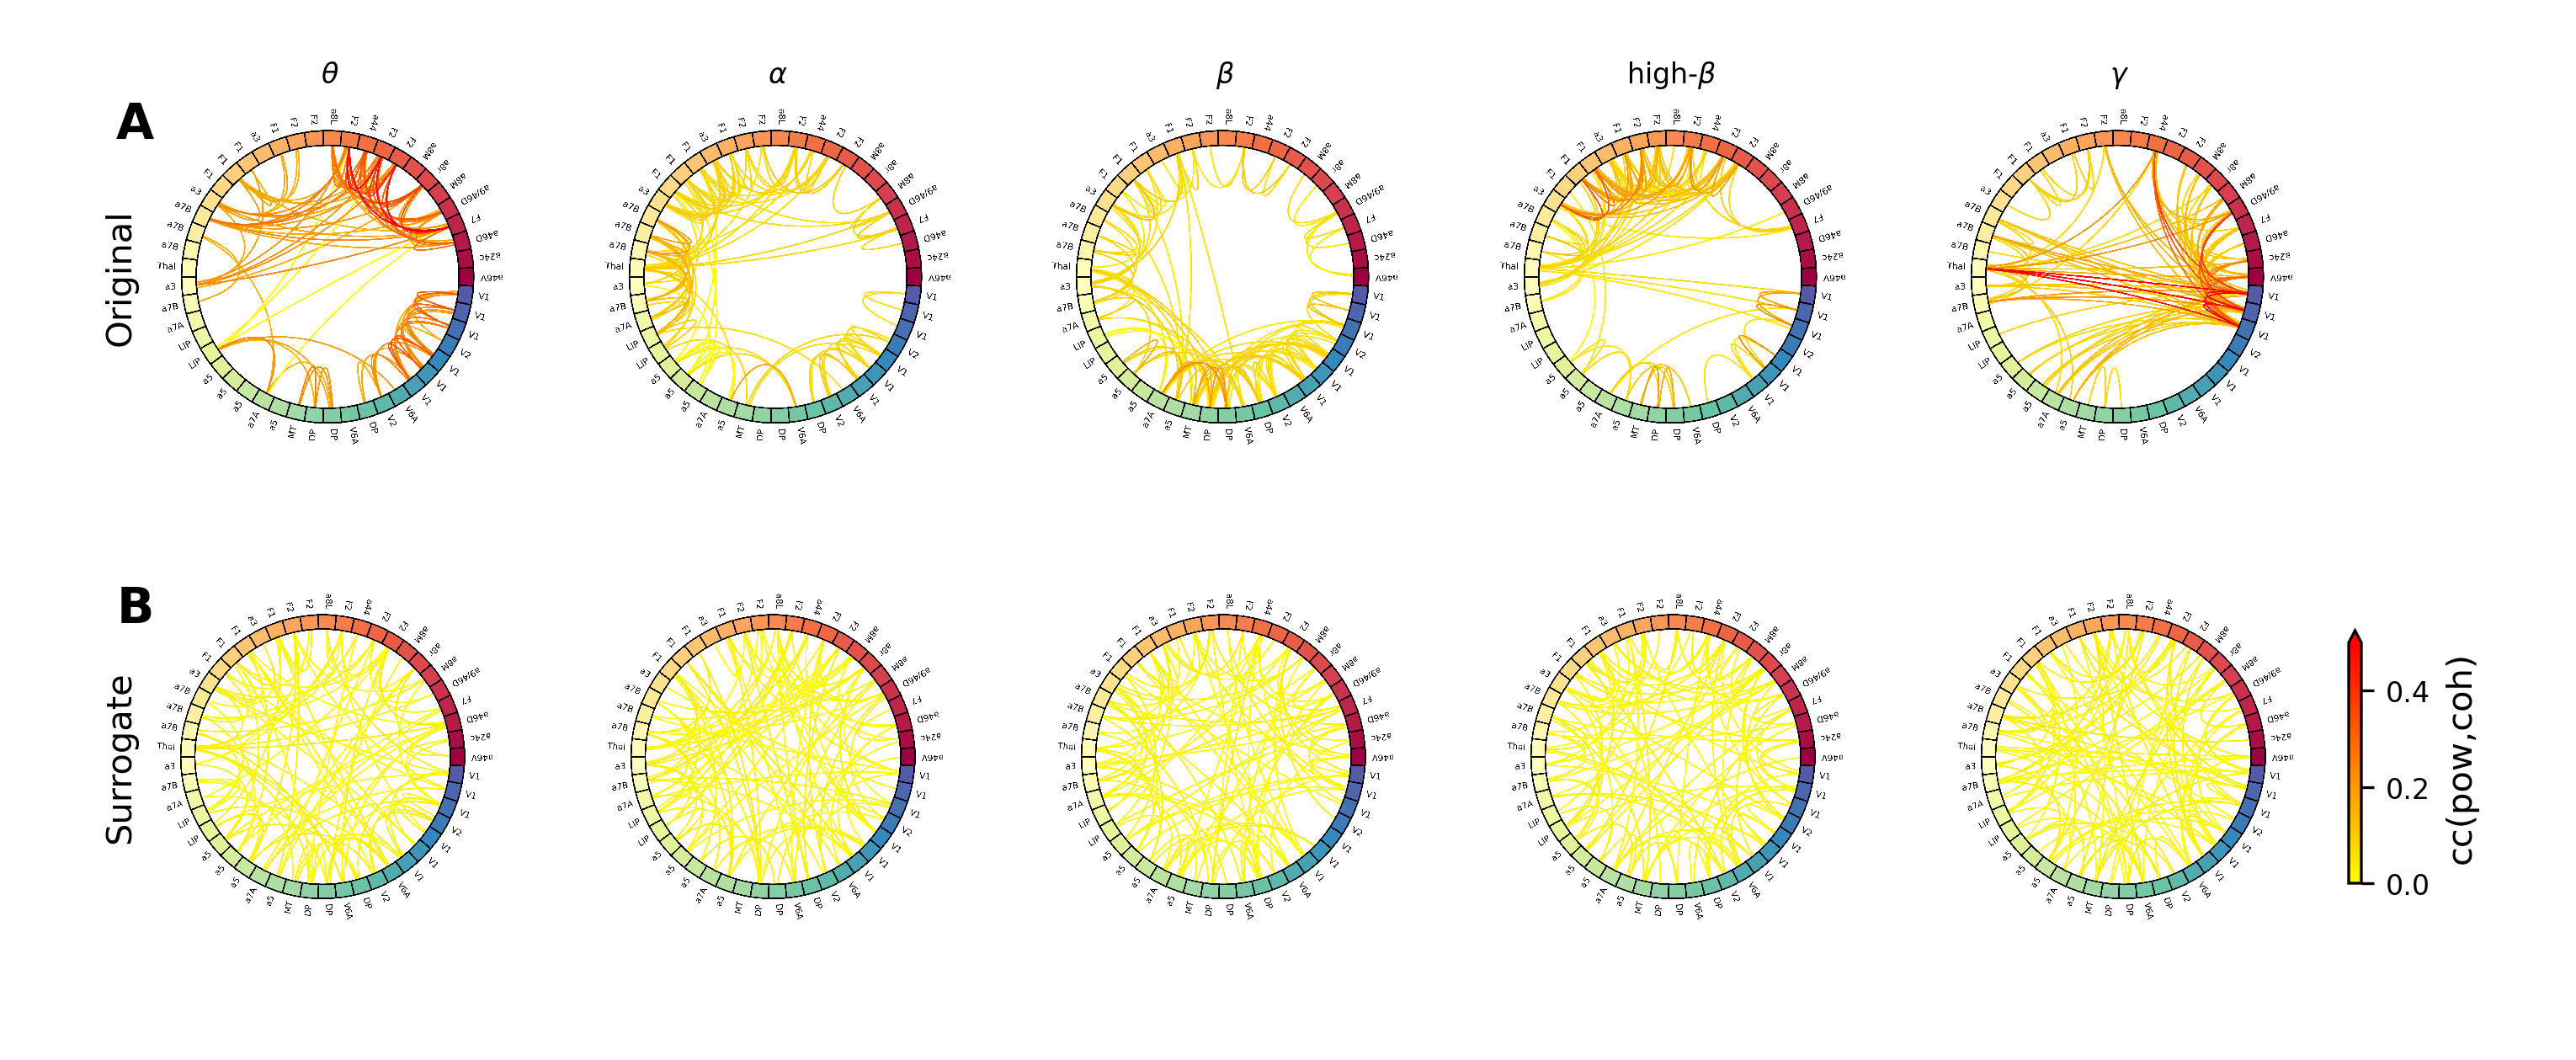

In [25]:
fig = plt.figure(figsize=(10, 4), dpi=300)

gs1 = fig.add_gridspec(nrows=1, ncols=6, width_ratios=(1,1,1,1,1,0.1),  left=0.05, right=0.95, bottom=0.55, top=0.95, wspace=0.3)
gs2 = fig.add_gridspec(nrows=1, ncols=5, width_ratios=(1,1,1,1,1), left=0.05, right=0.9, bottom=0.05, top=0.50, wspace=0.3)
gs3 = fig.add_gridspec(nrows=1, ncols=1, left=0.92, right=0.925, bottom=0.15, top=0.40)

# Panel A
ax1 = plt.subplot(gs1[0])
ax2 = plt.subplot(gs1[1])
ax3 = plt.subplot(gs1[2])
ax4 = plt.subplot(gs1[3])
ax5 = plt.subplot(gs1[4])
ax6 = plt.subplot(gs1[5])

plot_circles(ax1, 0, surr=False)
plt.title(f"{band_names[0]}")
plt.ylabel("Original")
plot_circles(ax2, 1, surr=False)
plt.title(f"{band_names[1]}")
plot_circles(ax3, 2, surr=False)
plt.title(f"{band_names[2]}")
plot_circles(ax4, 3, surr=False)
plt.title(f"{band_names[3]}")
plot_circles(ax5, 4, surr=False)
plt.title(f"{band_names[4]}")

# COLORBAR
#norm = matplotlib.colors.Normalize(vmin=0, vmax=0.5)
#cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.hot_r, norm=norm), cax=ax6, extend="max", shrink=0.1)
#cbar.ax.set_ylabel("cc(pow,coh)", rotation='vertical')

plt.sca(ax6)
plt.axis("off")

# Panel B
ax7  = plt.subplot(gs2[0])
plt.ylabel("Surrogate")
ax8  = plt.subplot(gs2[1])
ax9  = plt.subplot(gs2[2])
ax10 = plt.subplot(gs2[3])
ax11 = plt.subplot(gs2[4])
ax12 = plt.subplot(gs3[0])

plot_circles(ax7, 0,  surr=True)
plot_circles(ax8, 1,  surr=True)
plot_circles(ax9, 2,  surr=True)
plot_circles(ax10, 3, surr=True)
plot_circles(ax11, 4, surr=True)

ax_list = fig.get_axes()
for i in range(11):
    ax_list[i].set_yticklabels([])
    ax_list[i].set_xticklabels([])
    ax_list[i].set_xticks([])
    ax_list[i].set_yticks([])
    ax_list[i].spines['top'].set_visible(False)
    ax_list[i].spines['bottom'].set_visible(False)
    ax_list[i].spines['left'].set_visible(False)
    ax_list[i].spines['right'].set_visible(False)

# COLORBAR
norm = matplotlib.colors.Normalize(vmin=0, vmax=0.5)
cbar = plt.colorbar(mappable=plt.cm.ScalarMappable(cmap=matplotlib.cm.autumn_r, norm=norm), cax=ax12, extend="max", shrink=0.1)
cbar.ax.set_ylabel("cc(pow,coh)", rotation='vertical')

plot.add_panel_letters(fig, axes=[ax1, ax7], fontsize=14,
                   xpos=[-0.1]*4, ypos=[0.9]*4);

bg = plot.Background(visible=False)
plt.savefig("img/n5.1.0/cc_pow_coh_circle.png")